In [1]:
import yfinance as yf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import torch
import torch.nn as nn
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


mm = MinMaxScaler()
ss = StandardScaler()


#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [2]:
data = yf.download('USDJPY=X', interval='1m').reset_index()
data.columns = ['timestamp', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
data = data.set_index('timestamp')
data['delta'] = data['close']/data['open'] - 1
data = data[['open', 'close', 'adj_close', 'delta']]

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data

In [3]:
start_length = int(len(data)*0.5)
data = data.iloc[-start_length:]

In [4]:
'''
plt.plot(data['close'])
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("USDJPY price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();
'''

'\nplt.plot(data[\'close\'])\nplt.xlabel("Time")\nplt.ylabel("Price (USD)")\nplt.title("USDJPY price over time")\nplt.savefig("initial_plot.png", dpi=250)\nplt.show();\n'

In [5]:
X, y = data.drop(columns=['close']), data['close'].values
X.shape, y.shape

((3525, 3), (3525,))

In [31]:
data.tail()

,open,close,adj_close,delta
timestamp,,,,
2024-06-03 05:57:00+01:00,157.406998,157.408997,157.408997,0.000013
2024-06-03 05:58:00+01:00,157.406006,157.412003,157.412003,0.000038
2024-06-03 05:59:00+01:00,157.406998,157.412003,157.412003,0.000032
2024-06-03 06:00:00+01:00,157.408997,157.410004,157.410004,0.000006
2024-06-03 06:01:00+01:00,157.414993,157.414993,157.414993,0.000000


In [6]:
X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [7]:
output_length = 4
input_length = int(output_length*3)
window_length = 1

In [8]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out, window):
    assert n_steps_out > window
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1    #why -1?
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): 
            break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1+window:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, input_length, output_length, window_length)
print(X_ss.shape, y_mm.shape)

(3511, 12, 3) (3511, 3)


In [9]:
X_ss[-1]

array([[ 0.98293587,  0.98229863, -0.01377592],
       [ 0.98293587,  0.99466753,  0.23307581],
       [ 0.99218848,  0.97611418, -0.32186364],
       [ 0.9798202 ,  0.97611418, -0.07501815],
       [ 0.9798202 ,  0.954445  , -0.50748254],
       [ 0.95196795,  0.97299835,  0.4187132 ],
       [ 0.96438345,  0.9420761 , -0.44625401],
       [ 0.9365312 ,  0.95751362,  0.41778464],
       [ 0.94889949,  0.9791828 ,  0.60339654],
       [ 0.96126777,  0.97299835,  0.2330868 ],
       [ 0.97363606,  0.9791828 ,  0.1096523 ],
       [ 0.97056759,  0.98848308,  0.35651108]])

In [10]:
y_mm[-1]

array([0.77301022, 0.77145102, 0.77534309])

In [11]:
assert y_mm[0].all() == y_trans[input_length-1:input_length-1+output_length].squeeze(1).all()

In [12]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:train_test_cutoff]
X_test = X_ss[train_test_cutoff:]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (3172, 12, 3) (3172, 3)
Testing Shape: (339, 12, 3) (339, 3)


In [13]:
# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [14]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], input_length, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], input_length, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([3172, 12, 3]) torch.Size([3172, 3])
Testing Shape: torch.Size([339, 12, 3]) torch.Size([339, 3])


In [15]:
#This doesnt seem to be used for anything

#X_check, y_check = split_sequences(X, y.reshape(-1, 1), input_length, output_length, window_length)
#X_check[-1][0:4]

array([[ 1.57410004e+02,  1.57410004e+02,  0.00000000e+00],
       [ 1.57410004e+02,  1.57414001e+02,  2.53973867e-05],
       [ 1.57412994e+02,  1.57408005e+02, -3.16976628e-05],
       [ 1.57408997e+02,  1.57408005e+02, -6.30091869e-06]])

In [16]:
#This doesnt seem to be used for anything

#data['close'].values[-output_length:]

array([157.41200256, 157.41200256, 157.41000366, 157.41499329])

In [17]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes  # output size
        self.num_layers = num_layers  # number of recurrent layers in the lstm
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)  # lstm
        # self.fc_1 = nn.Linear(hidden_size, 16)  # first fully connected layer
        # self.fc_2 = nn.Linear(128, 64)  # second fully connected layer
        # self.fc_3 = nn.Linear(32, 16)  # second fully connected layer
        self.fc_2 = nn.Linear(hidden_size, num_classes)  # third fully connected layer, adjusted to output size
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Initialize hidden and cell states
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # (input, hidden, and cell state)
        hn = hn[-1,:,:]  # Get the last layer's output to feed to the dense layers
        out = self.relu(hn)
        # out = self.fc_1(out)  # first dense layer
        # out = self.relu(out)  # relu
        # out = self.dropout1(out)
        out = self.fc_2(out)  # second dense layer
        out = self.relu(out)  # relu
        # out = self.dropout1(out)
        # out = self.fc_3(out)  # second dense layer
        # out = self.relu(out)  # relu
        return out

In [18]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, checkpoint_filename='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.checkpoint_filename = checkpoint_filename

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.checkpoint_filename)  # Save your model
        self.val_loss_min = val_loss



In [19]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test, checkpoint_filename='checkpoint.pt'):
        # Initialize the early stopping object
        early_stopping = EarlyStopping(patience=10, verbose=False, checkpoint_filename=checkpoint_filename)

        for epoch in range(n_epochs):
            lstm.train()
            outputs = lstm.forward(X_train)  # forward pass
            optimiser.zero_grad()  # calculate the gradient, manually setting to 0
            loss = loss_fn(outputs, y_train)  # obtain the loss function
            loss.backward()  # calculates the loss of the loss function
            optimiser.step()  # improve from loss, i.e backprop

            # Evaluation with the test set
            lstm.eval()
            test_preds = lstm(X_test)
            test_loss = loss_fn(test_preds, y_test)

            if epoch % 100 == 0:
                print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss.item()))

            # Early stopping
            early_stopping(test_loss.item(), lstm)
            if early_stopping.early_stop:
                print("Early stopping")
                break
        # Load the last checkpoint with the best model
        lstm.load_state_dict(torch.load(checkpoint_filename))

In [20]:
n_epochs = 2000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X.shape[1] # number of features
hidden_size = 8 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = output_length-window_length # number of output classes 

lstm = LSTM(num_classes, 
            input_size, 
            hidden_size, 
            num_layers)

/Users/benny/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [21]:
loss_fn = nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors, 
              checkpoint_filename='forex_checkpoint.pt')

Epoch: 0, train loss: 0.18481, test loss: 0.21661
Epoch: 100, train loss: 0.03830, test loss: 0.03427
Early stopping


In [22]:
lstm.load_state_dict(torch.load('forex_checkpoint.pt'))

<All keys matched successfully>

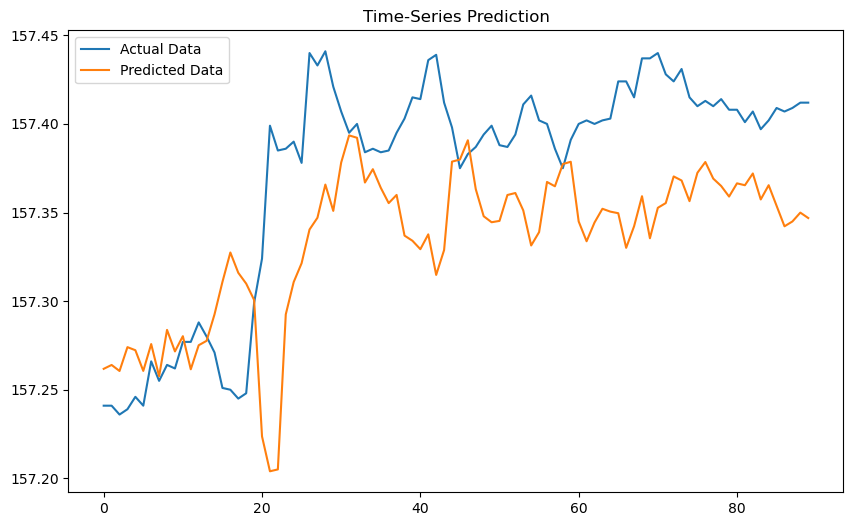

339


In [23]:
df_X_ss = ss.transform(data.drop(columns=['close'])) # old transformers
df_y_mm = mm.transform(data['close'].values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, input_length, output_length, window_length)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], input_length, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot) - 90, len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(dataY_plot) - 90, len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
# plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 
print(len(dataY_plot)-train_test_cutoff)

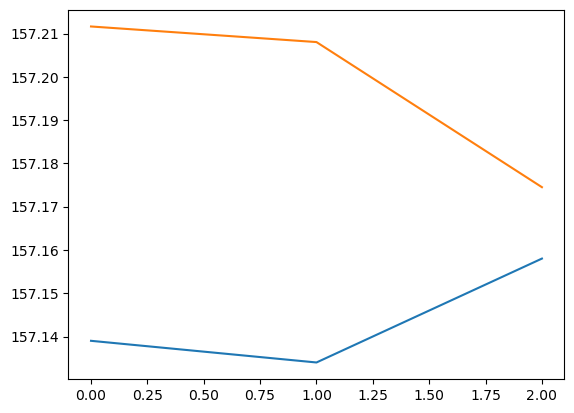

In [24]:
idx = 250
test_predict = lstm(X_test_tensors_final[-idx].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)

test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-idx].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show();

In [25]:
mse_ls = list()

from sklearn.metrics import mean_squared_error

for idx in range(len(X_test_tensors_final)):
    test_predict = lstm(X_test_tensors_final[idx].unsqueeze(0)) # get the last sample
    test_predict = test_predict.detach().numpy()
    test_predict = mm.inverse_transform(test_predict)

    test_predict = test_predict[0].tolist()

    test_target = y_test_tensors[idx].detach().numpy() # last sample again
    test_target = mm.inverse_transform(test_target.reshape(1, -1))
    test_target = test_target[0].tolist()

    mse = mean_squared_error(test_predict, test_target)
    mse_ls.append(mse)

In [26]:
print(np.max(mse_ls))
print(np.mean(mse_ls))
print(np.median(mse_ls))
print(np.min(mse_ls))

0.022588171064853668
0.0034092062543491547
0.0018449364385257165
1.878112864991029e-05


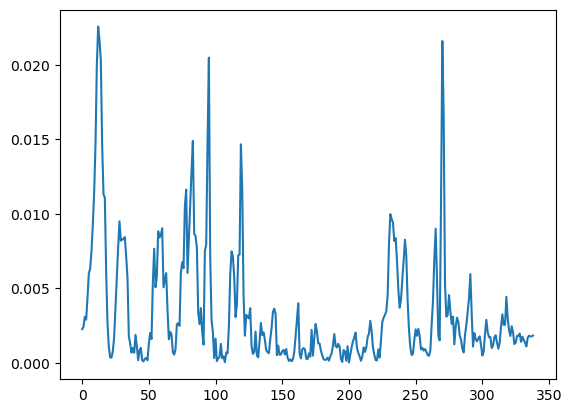

In [27]:
plt.plot(mse_ls)

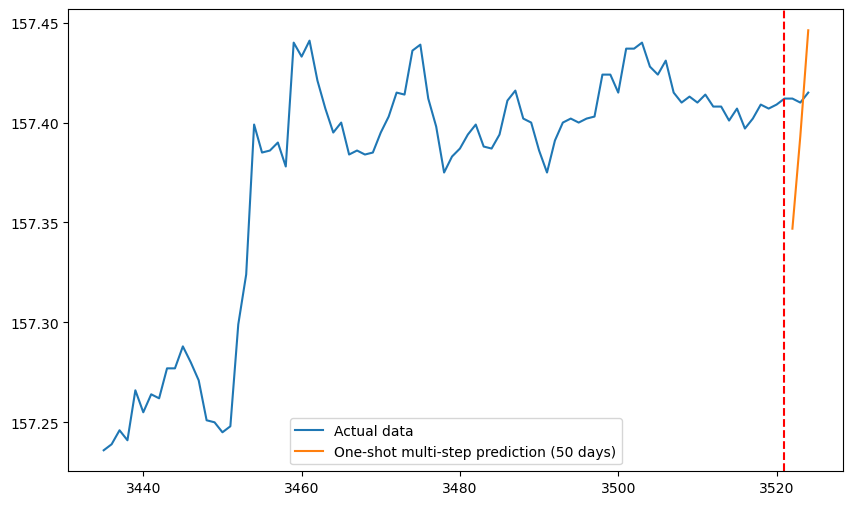

In [28]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(len(y)-90, len(y))]
plt.plot(a, y[(len(y)-90):], label='Actual data');
c = [x for x in range(len(y)-output_length+window_length, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-output_length, c='r', linestyle='--')
plt.legend()
plt.show()

In [29]:
#https://ibkrcampus.com/ibkr-api-page/twsapi-doc/#connectivity
#https://algotrading101.com/learn/interactive-brokers-python-api-native-guide/

import hermes.broker.ibkr as ibkr
import hermes.broker.ibkr.orders as o

# optional settings; if not given to ibkr.InteractiveBroker, the class uses these as defaults
host = 'localhost'
port = 7497         # this must match the socket port value in IB Gateway/TWS setting
client_id = 0

ModuleNotFoundError: No module named 'hermes'

In [ ]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract

In [ ]:
class TradeApp(EWrapper, EClient): 
    def __init__(self): 
        EClient.__init__(self, self) 
    def contractDetails(self, reqId: int, contractDetails: ContractDetails):
        print(reqId, contractDetails)
    def contractDetailsEnd(self, reqId: int):
        print("ContractDetailsEnd. ReqId:", reqId)
def websocket_con():
    app.run()
    
app = TradeApp()      
app.connect("127.0.0.1", 7497, clientId=1)
con_thread = threading.Thread(target=websocket_con, daemon=True)
con_thread.start()
time.sleep(1) 
contract = Contract() 
contract.symbol = "AAPL" 
contract.secType = "STK" 
contract.currency = "USD" 
contract.exchange = "SMART" 
app.reqContractDetails(123, contract)

In [ ]:
def contractDetails(self, reqId: int, contractDetails: ContractDetails):
  print(reqId, contractDetails)

In [ ]:
class TradeApp(EWrapper, EClient): 
    def __init__(self): 
        EClient.__init__(self, self) 
        
    def historicalData(self, reqId, bar):
        print("HistoricalData. ReqId:", reqId, "BarData.", bar)
    def historicalSchedule(self, reqId: int, startDateTime: str, endDateTime: str, timeZone: str, sessions: ListOfHistoricalSessions):
        print("HistoricalSchedule. ReqId:", reqId, "Start:", startDateTime, "End:", endDateTime, "TimeZone:", timeZone)
        for session in sessions:
            print("\tSession. Start:", session.startDateTime, "End:", session.endDateTime, "Ref Date:", session.refDate)
    def historicalDataUpdate(self, reqId: int, bar: BarData):
        print("HistoricalDataUpdate. ReqId:", reqId, "BarData.", bar)
    def historicalDataEnd(self, reqId: int, start: str, end: str):
        print("HistoricalDataEnd. ReqId:", reqId, "from", start, "to", end)
def websocket_con():
    app.run()
    
app = TradeApp()      
app.connect("127.0.0.1", 7496, clientId=1)
con_thread = threading.Thread(target=websocket_con, daemon=True)
con_thread.start()
time.sleep(1) 
contract = Contract()
contract.symbol = "AAPL"
contract.secType = "STK"
contract.exchange = "SMART"
contract.currency = "USD"
app.reqHistoricalData(reqId=101, 
                          contract=contract,
                          endDateTime='', 
                          durationStr='1 D',
                          barSizeSetting='1 hour',
                          whatToShow='Trades',
                          useRTH=0,                 #0 = Includes data outside of RTH | 1 = RTH data only 
                          formatDate=1,    
                          keepUpToDate=1,           #0 = False | 1 = True 
                          chartOptions=[])

In [ ]:
impo